In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [2]:
ddir = '/swot/SUM02/as4479/POP_nn600batch_predictions/'

In [3]:
ds = xr.open_mfdataset(ddir+'*.nc', chunks={'time': 1})
ds

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600, time: 365)
Coordinates:
  * nlon      (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * nlat      (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * time      (time) datetime64[ns] 1951-01-01 1951-01-02 ... 1951-12-31
Data variables:
    mask_tot  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    mask_lat  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    mask_geo  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    u_t_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    v_t_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    u_n_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    v_n_um    (time, nlat, nlon) float32 dask.array<shap

In [4]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 18, 'axes.labelsize' : 13,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (12.,7.5)


In [5]:
figdir = 'Figs_NN/'

In [6]:
ds_snap0 = ds.isel(time=176).load()
ds_snap=ds_snap0.isel(nlat=slice(200,1000))

In [7]:
def mean_abs_error(a,b):
    mae=(np.abs(a-b)).mean()
    return mae
def bias(a,b):
    bias = a.mean() -b.mean()
    return bias
def mean_square_error(a,b):
    mse = ((a-b)**2).mean()
    return mse
def root_mean_square_error(a,b):
    rmse = np.sqrt(((a-b)**2).mean())
    return rmse
def mean_abs_error_2(u1,v1,u2,v2):
    mae = (np.abs(u2-u1) + np.abs(v2-v1)).mean()
    return mae

def mean_square_error_2(u1,v1,u2,v2):
    mse = ((u2-u1)**2+(v2-v1)**2).mean()
    return mse
def root_mean_square_error_2(u1,v1,u2,v2):
    rmse = np.sqrt(((u2-u1)**2+(v2-v1)**2).mean())
    return rmse

def angle_diff(u1,v1,u2,v2):
    theta =(np.arccos((u1*u2 + v1*v2)/(np.sqrt(u1**2+v1**2)*np.sqrt(u2**2+v2**2)))).mean()
    return theta


In [8]:
Err = {}
Err['MAE_tot_n'] = mean_abs_error_2(ds_snap.u_n,ds_snap.v_n, ds_snap.u_t, ds_snap.v_t)
Err['MAE_tot_ge'] = mean_abs_error_2(ds_snap.u_ge,ds_snap.v_ge, ds_snap.u_t, ds_snap.v_t)
Err['MAE_tot_g'] = mean_abs_error_2(ds_snap.u_g,ds_snap.v_g, ds_snap.u_t, ds_snap.v_t)
Err['MSE_tot_n'] = mean_square_error_2(ds_snap.u_n,ds_snap.v_n, ds_snap.u_t, ds_snap.v_t)
Err['MSE_tot_ge'] = mean_square_error_2(ds_snap.u_ge,ds_snap.v_ge, ds_snap.u_t, ds_snap.v_t)
Err['MSE_tot_g'] = mean_square_error_2(ds_snap.u_g,ds_snap.v_g, ds_snap.u_t, ds_snap.v_t)

Err['angle_n'] = angle_diff(ds_snap.u_n,ds_snap.v_n, ds_snap.u_t, ds_snap.v_t)
Err['angle_ge'] = angle_diff(ds_snap.u_ge,ds_snap.v_ge, ds_snap.u_t, ds_snap.v_t)
Err['angle_g'] = angle_diff(ds_snap.u_g,ds_snap.v_g, ds_snap.u_t, ds_snap.v_t)

Err['MAE_u_n'] = mean_abs_error(ds_snap.u_n, ds_snap.u_t)
Err['MAE_v_n'] = mean_abs_error(ds_snap.v_n, ds_snap.v_t)
Err['MAE_u_ge'] = mean_abs_error(ds_snap.u_ge, ds_snap.u_t)
Err['MAE_v_ge'] = mean_abs_error(ds_snap.v_ge, ds_snap.v_t)
Err['MAE_u_g'] = mean_abs_error(ds_snap.u_g, ds_snap.u_t)
Err['MAE_v_g'] = mean_abs_error(ds_snap.v_g, ds_snap.v_t)

Err['MSE_u_n'] = mean_square_error(ds_snap.u_n, ds_snap.u_t)
Err['MSE_v_n'] = mean_square_error(ds_snap.v_n, ds_snap.v_t)
Err['MSE_u_ge'] = mean_square_error(ds_snap.u_ge, ds_snap.u_t)
Err['MSE_v_ge'] = mean_square_error(ds_snap.v_ge, ds_snap.v_t)
Err['MSE_u_g'] = mean_square_error(ds_snap.u_g, ds_snap.u_t)
Err['MSE_v_g'] = mean_square_error(ds_snap.v_g, ds_snap.v_t)

Err['bias_u_n'] = bias(ds_snap.u_n, ds_snap.u_t)
Err['bias_v_n'] = bias(ds_snap.v_n, ds_snap.v_t)
Err['bias_u_ge'] = bias(ds_snap.u_ge, ds_snap.u_t)
Err['bias_v_ge'] = bias(ds_snap.v_ge, ds_snap.v_t)
Err['bias_u_g'] = bias(ds_snap.u_g, ds_snap.u_t)
Err['bias_v_g'] = bias(ds_snap.v_g, ds_snap.v_t)


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


In [9]:
XU = ds_snap.XU.values
YU = ds_snap.YU.values

In [10]:
x,y = np.meshgrid(np.roll(XU[200], 700),YU[:,200])

In [11]:
vels = {}
vels['u_t'] = np.roll(ds_snap.u_t.values, 700, axis=1)
vels['v_t'] = np.roll(ds_snap.v_t.values, 700, axis=1)
vels['u_n'] = np.roll(ds_snap.u_n.values, 700, axis=1)
vels['v_n'] = np.roll(ds_snap.v_n.values, 700, axis=1)
#vels['u_ge'] = np.roll(ds_snap.u_ge.values, 700, axis=1)
#vels['v_ge'] = np.roll(ds_snap.v_ge.values, 700, axis=1)
vels['u_g'] = np.roll(ds_snap.u_g.values, 700, axis=1)
vels['v_g'] = np.roll(ds_snap.v_g.values, 700, axis=1)
vels['u_ge'] = np.roll(ds_snap.u_g.values, 700, axis=1)+np.sqrt(10)*np.roll(ds_snap.u_e.values, 700, axis=1)
vels['v_ge'] = np.roll(ds_snap.v_g.values, 700, axis=1)+np.sqrt(10)*np.roll(ds_snap.u_e.values, 700, axis=1)

vels['ae_u_n'] = np.abs(vels['u_n'] - vels['u_t'])
vels['ae_v_n'] = np.abs(vels['v_n'] - vels['v_t'])

vels['ae_u_ge'] = np.abs(vels['u_ge'] - vels['u_t'])
vels['ae_v_ge'] = np.abs(vels['v_ge'] - vels['v_t'])

vels['ae_u_g'] = np.abs(vels['u_g'] - vels['u_t'])
vels['ae_v_g'] = np.abs(vels['v_g'] - vels['v_t'])



In [12]:
errs = {}
errs['mae_u_n'] = np.nanmean((np.abs(vels['u_n']-vels['u_t'])))
errs['mae_v_n'] = np.nanmean((np.abs(vels['v_n']-vels['v_t'])))
errs['rmse_u_n'] = np.sqrt(np.nanmean((vels['u_n']-vels['u_t'])**2))
errs['rmse_v_n'] = np.sqrt(np.nanmean((vels['v_n']-vels['v_t'])**2))

errs['bias_u_n'] = np.nanmean(vels['u_n']) - np.nanmean(vels['u_t'])
errs['bias_v_n'] = np.nanmean(vels['v_n']) - np.nanmean(vels['v_t'])


errs['mae_u_ge'] = np.nanmean((np.abs(vels['u_ge']-vels['u_t'])))
errs['mae_v_ge'] = np.nanmean((np.abs(vels['v_ge']-vels['v_t'])))
errs['rmse_u_ge'] = np.sqrt(np.nanmean((vels['u_ge']-vels['u_t'])**2))
errs['rmse_v_ge'] = np.sqrt(np.nanmean((vels['v_ge']-vels['v_t'])**2))

errs['bias_u_ge'] = np.nanmean(vels['u_ge']) - np.nanmean(vels['u_t'])
errs['bias_v_ge'] = np.nanmean(vels['v_ge']) - np.nanmean(vels['v_t'])


errs['mae_u_g'] = np.nanmean((np.abs(vels['u_g']-vels['u_t'])))
errs['mae_v_g'] = np.nanmean((np.abs(vels['v_g']-vels['v_t'])))
errs['rmse_u_g'] = np.sqrt(np.nanmean((vels['u_g']-vels['u_t'])**2))
errs['rmse_v_g'] = np.sqrt(np.nanmean((vels['v_g']-vels['v_t'])**2))

errs['bias_u_g'] = np.nanmean(vels['u_g']) - np.nanmean(vels['u_t'])
errs['bias_v_g'] = np.nanmean(vels['v_g']) - np.nanmean(vels['v_t'])

errs['theta_n'] =np.nanmean((np.arccos((vels['u_n']*vels['u_t'] + vels['v_n']*vels['v_t'])/
                            (np.sqrt(vels['u_n']**2+vels['v_n']**2)*np.sqrt(vels['u_t']**2+vels['v_t']**2)))))

errs['theta_ge'] =np.nanmean((np.arccos((vels['u_ge']*vels['u_t'] + vels['v_ge']*vels['v_t'])/
                            (np.sqrt(vels['u_ge']**2+vels['v_ge']**2)*np.sqrt(vels['u_t']**2+vels['v_t']**2)))))

errs['theta_g'] =np.nanmean((np.arccos((vels['u_g']*vels['u_t'] + vels['v_g']*vels['v_t'])/
                            (np.sqrt(vels['u_g']**2+vels['v_g']**2)*np.sqrt(vels['u_t']**2+vels['v_t']**2)))))


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in arccos
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in arccos
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in arccos


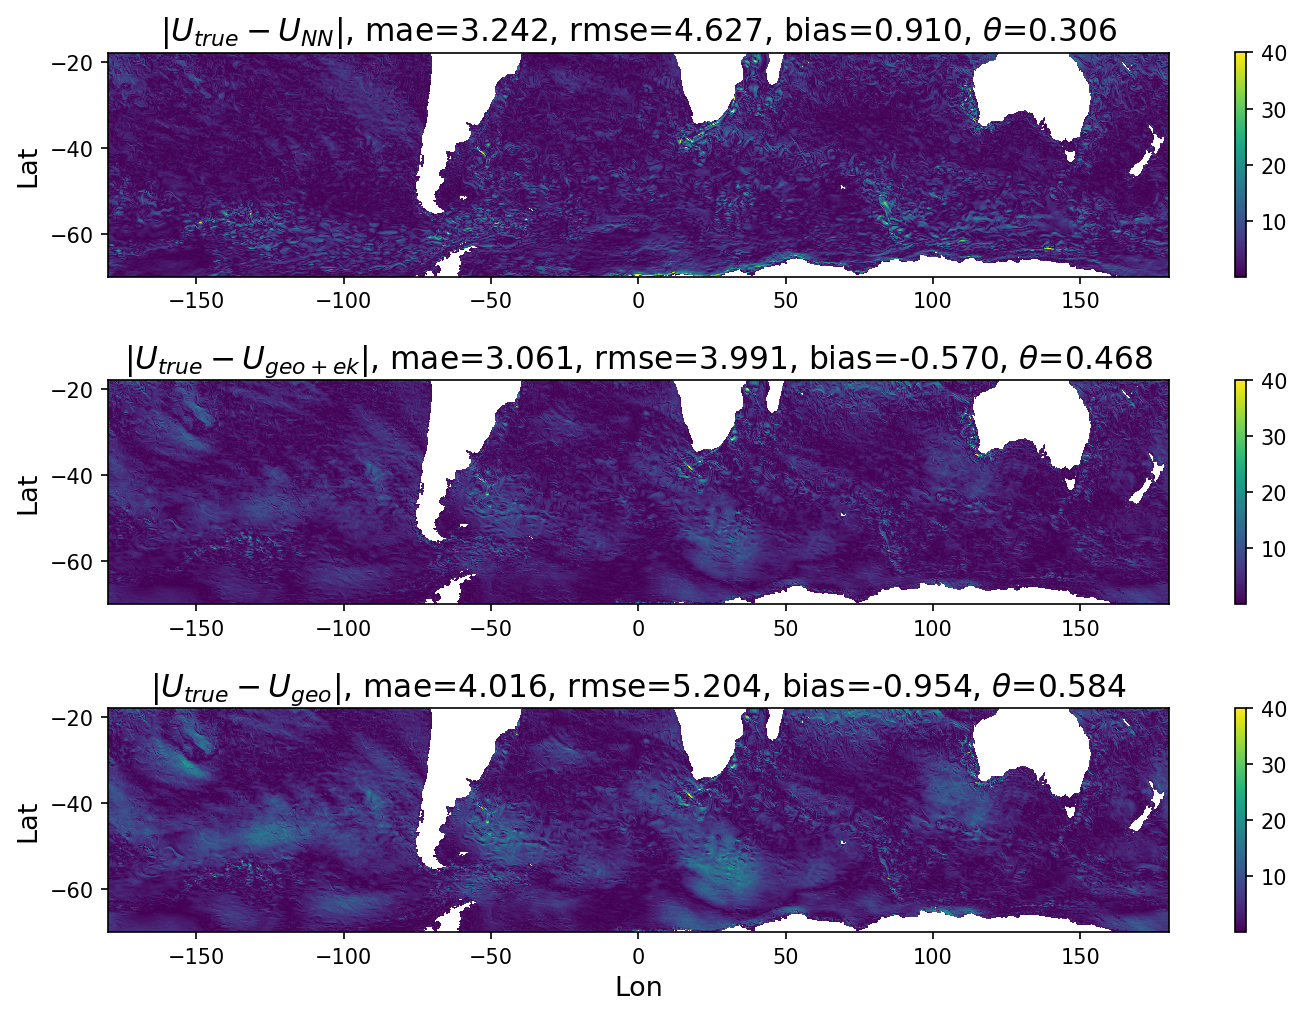

In [13]:
fig = plt.figure(figsize=(9,7),dpi=150)

plt.subplot(311)
plt.pcolormesh(x,y,vels['ae_u_n'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|U_{true} - U_{NN}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_u_n'],errs['rmse_u_n'],errs['bias_u_n'], errs['theta_n']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')
plt.subplot(312)
plt.pcolormesh(x,y,vels['ae_u_ge'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|U_{true} - U_{geo+ek}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_u_ge'],errs['rmse_u_ge'],errs['bias_u_ge'], errs['theta_ge']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')

plt.subplot(313)
plt.pcolormesh(x,y,vels['ae_u_g'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|U_{true} - U_{geo}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_u_g'],errs['rmse_u_g'],errs['bias_u_g'], errs['theta_g']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')
plt.xlabel('Lon')

plt.tight_layout(rect=[0,0,1.1,1])
fig.savefig(figdir+'AE_U_SO_600batch.png')
fig.savefig(figdir+'AE_U_SO_600batch.pdf',dpi=200)
fig.savefig(figdir+'AE_U_SO_600batch_150dpi.pdf',dpi=150)


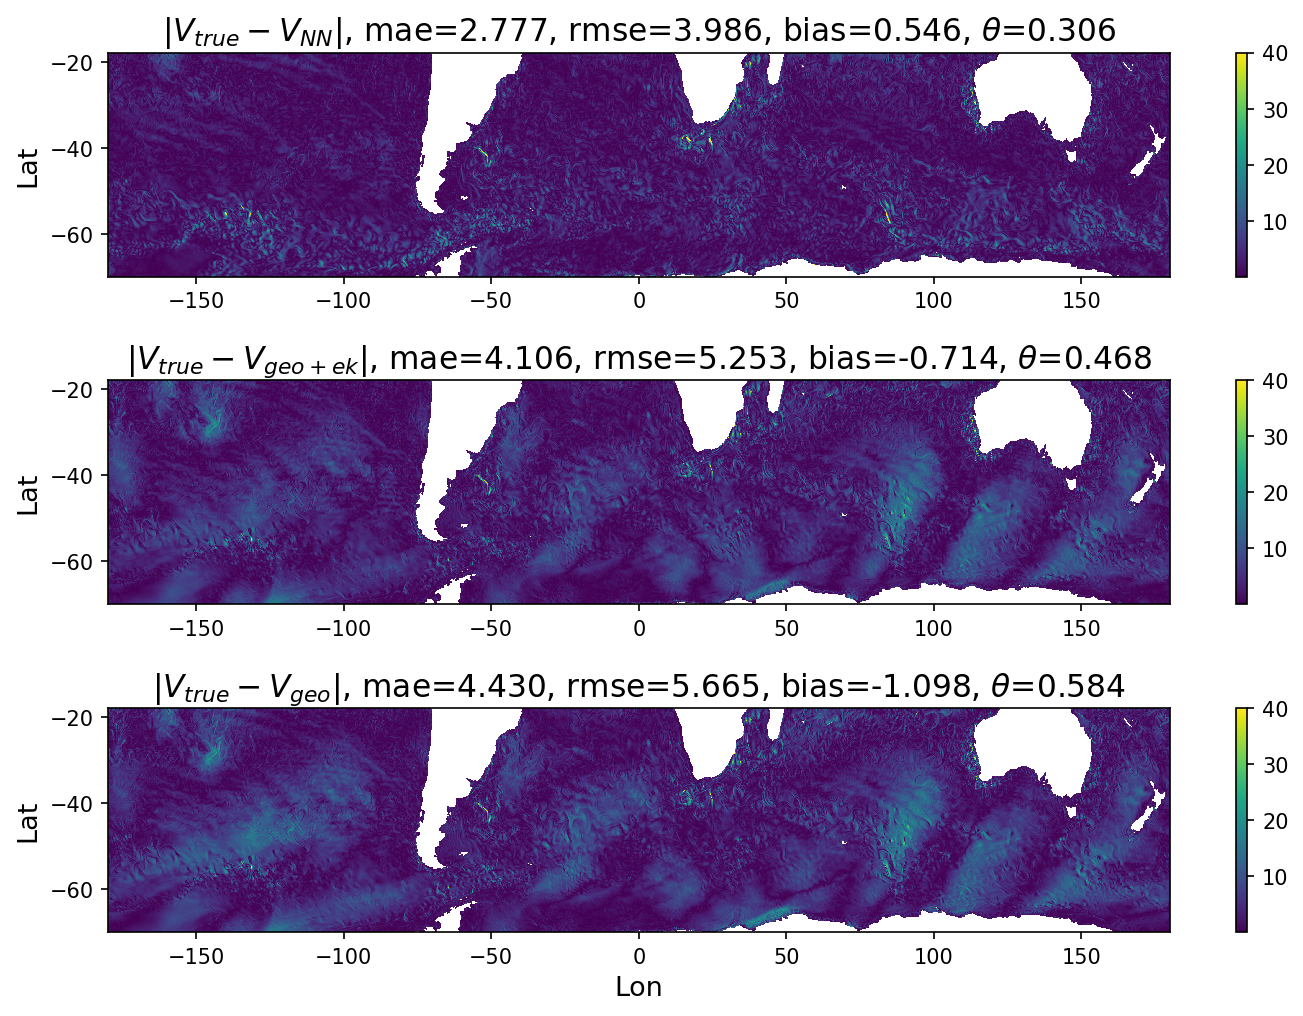

In [14]:
fig = plt.figure(figsize=(9,7),dpi=150)

plt.subplot(311)
plt.pcolormesh(x,y,vels['ae_v_n'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|V_{true} - V_{NN}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_v_n'],errs['rmse_v_n'],errs['bias_v_n'], errs['theta_n']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')
plt.subplot(312)
plt.pcolormesh(x,y,vels['ae_v_ge'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|V_{true} - V_{geo+ek}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_v_ge'],errs['rmse_v_ge'],errs['bias_v_ge'], errs['theta_ge']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')

plt.subplot(313)
plt.pcolormesh(x,y,vels['ae_v_g'], vmax=40, cmap='viridis', rasterized=True);
plt.title(r'$\|V_{true} - V_{geo}\|$, mae=%1.3f, rmse=%1.3f, bias=%1.3f, $\theta$=%1.3f'  
          %(errs['mae_v_g'],errs['rmse_v_g'],errs['bias_v_g'], errs['theta_g']), fontsize=15)
plt.colorbar()
plt.ylabel('Lat')
plt.xlabel('Lon')

plt.tight_layout(rect=[0,0,1.1,1])
fig.savefig(figdir+'AE_V_SO_600batch.png')
fig.savefig(figdir+'AE_V_SO_600batch.pdf',dpi=200)
fig.savefig(figdir+'AE_V_SO_600batch_150dpi.pdf',dpi=150)
